In [8]:
import pandas as pd
df=pd.read_csv('/home/dell/Documents/datasets/Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/14/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",NC,27519,NaN,Consent not provided,Web,03/14/2019,Closed with explanation,Yes,NaN,3179505.0
1,03/14/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CURO Intermediate Holdings,AZ,85040,NaN,NaN,Web,03/14/2019,Closed with explanation,Yes,NaN,3179861.0
2,03/14/2019,Vehicle loan or lease,Loan,Problem with a credit reporting company's inve...,Problem with personal statement of dispute,NaN,NaN,ALLY FINANCIAL INC.,MS,397XX,NaN,NaN,Web,03/14/2019,In progress,Yes,NaN,3179198.0
3,03/14/2019,Vehicle loan or lease,Loan,Improper use of your report,Reporting company used your report improperly,NaN,NaN,ALLY FINANCIAL INC.,MI,484XX,NaN,NaN,Referral,03/14/2019,In progress,Yes,NaN,3179501.0
4,03/14/2019,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,Bonneville Billing and Collections,FL,330XX,NaN,NaN,Web,03/14/2019,Closed with explanation,Yes,NaN,3179976.0


In [9]:
#Extract the data
from io import StringIO
col=['Product','Consumer complaint narrative']
df=df[col]
#non null values extraction
df=df[pd.notnull(df['Consumer complaint narrative'])]
df.columns=['Product','Consumer_complaint_narrative']
#to categorize the particular products
df['category_id']=df['Product'].factorize()[0]
category_id_df=df[['Product','category_id']].drop_duplicates().sort_values('category_id')
category_to_id=dict(category_id_df.values)
id_to_category=dict(category_id_df[['category_id','Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
5225,Debt collection,I have repeatedly tried to have company verify...,0
5552,Debt collection,Perfection Collection XXXX XXXX XXXX XXXX XXXX...,0
5761,Debt collection,ability recovery services had put a collection...,0
5814,"Credit reporting, credit repair services, or o...",My credit report showed me a hard inquiry made...,1
6289,Debt collection,XXXX XXXX XXXX is reporting a collection for X...,0


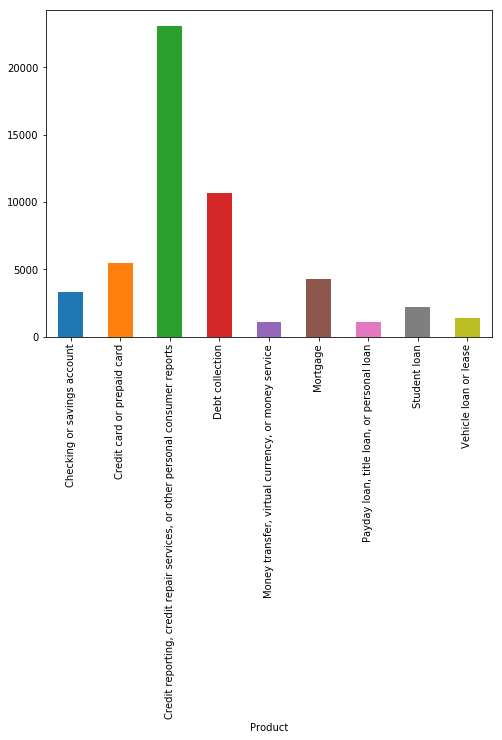

In [10]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [11]:
#unique and info

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(sublinear_tf=True,min_df=5,norm='l2',encoding='latin-1',ngram_range=(1,2),stop_words='english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
features=tfidf.fit_transform(df.Consumer_complaint_narrative)

In [18]:
labels=df.category_id
features.shape

(52529, 131712)

In [20]:
#scikit learn feature square chi2 test
from sklearn.feature_selection import chi2
import numpy as np
N=2
for Product,category_id in sorted(category_to_id.items()):
    features_chi2=chi2(features,labels==category_id)
    indices=np.argsort(features_chi2[0])
    feature_names=np.array(tfidf.get_feature_names())[indices]
    unigrams=[v for v in feature_names if len(v.split(' '))==1]
    bigrams=[v for v in feature_names if len(v.split(' '))==2]
    print("# '{}':".format(Product))
    print("  .most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  .most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Checking or savings account':
  .most correlated unigrams:
. overdraft
. deposit
  .most correlated bigrams:
. savings account
. checking account
# 'Credit card or prepaid card':
  .most correlated unigrams:
. express
. card
  .most correlated bigrams:
. american express
. credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  .most correlated unigrams:
. experian
. report
  .most correlated bigrams:
. mistakes appear
. credit report
# 'Debt collection':
  .most correlated unigrams:
. collection
. debt
  .most correlated bigrams:
. collection agency
. collect debt
# 'Money transfer, virtual currency, or money service':
  .most correlated unigrams:
. western
. paypal
  .most correlated bigrams:
. paypal account
. western union
# 'Mortgage':
  .most correlated unigrams:
. modification
. mortgage
  .most correlated bigrams:
. mortgage company
. loan modification
# 'Payday loan, title loan, or personal loan':
  .most correlated unigrams:
. borrow

# Multinomial Naive Bayes bcz multiclass classification



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


In [24]:
x_train,x_test,y_train,y_test=train_test_split(df['Consumer_complaint_narrative'],df['Product'],random_state=0)
count_vect=CountVectorizer()
x_train_counts=count_vect.fit_transform(x_train)
tfidf_transformer=TfidfTransformer()
x_train_tfidf=tfidf_transformer.fit_transform(x_train_counts)
clf=MultinomialNB()
clf.fit(x_train_tfidf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
print(clf.predict(count_vect.transform(["Incorrect information on your report"])))

['Credit reporting, credit repair services, or other personal consumer reports']


Text(0.5,69,'Predicted')

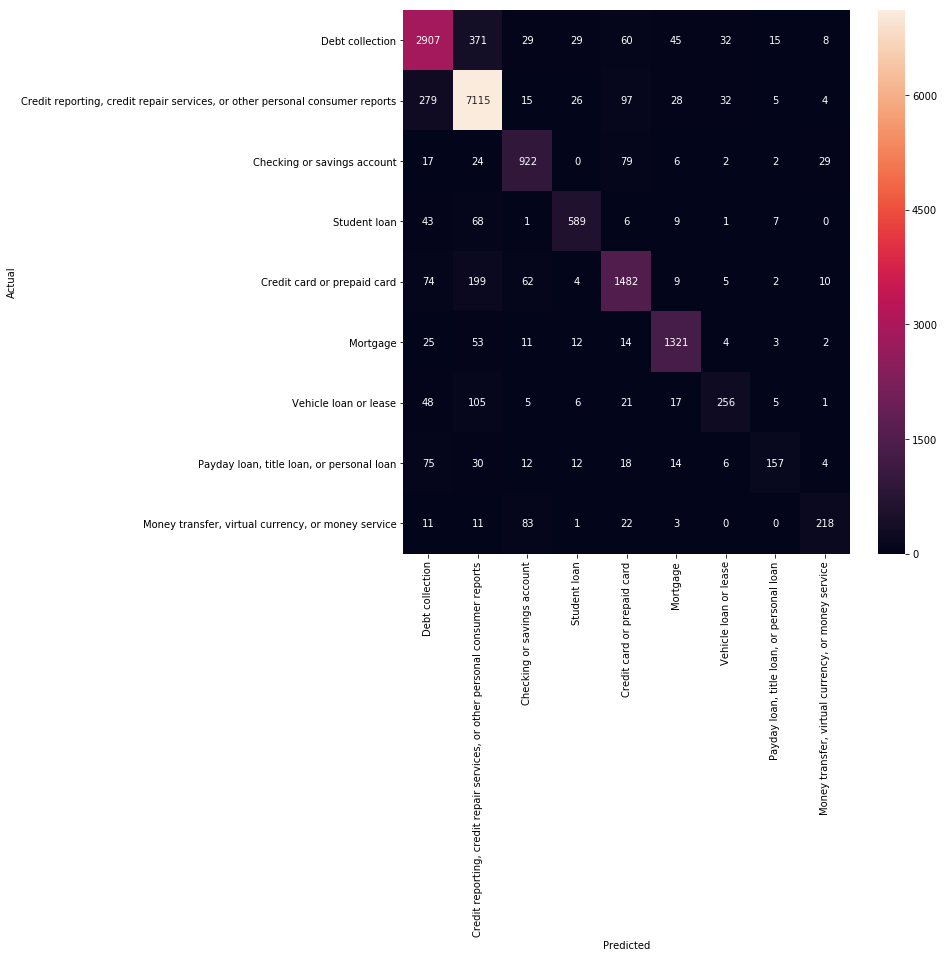

In [33]:
import seaborn as sns
from sklearn.svm import LinearSVC
model=LinearSVC()
x_train,x_test,y_train,y_test,indices_train,indices_test=train_test_split(features,labels,df.index,test_size=0.33,random_state=0)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_pred)
#conf_mat
#sns.heatmap(conf_mat,annot=True)

fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='d',xticklabels=category_id_df.Product.values,yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
